In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from datasets import load_dataset

test_dataset = load_dataset("jo-mengr/bowel_disease_single")["train"]

In [35]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("../../outputs/2025-02-14/09-35-31/model")

In [47]:
from mmcontext.utils import load_test_adata_from_hf_dataset

adata = load_test_adata_from_hf_dataset(test_dataset)

In [36]:
omics_embeddings = model.encode(test_dataset["anndata_ref"])
text_embeddings = model.encode(adata.obs["cluster_label"].values.tolist())
adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["mmcontext_text_emb"] = text_embeddings

In [37]:
from mmcontext.eval.utils import create_emb_pair_dataframe

emb_pair_df = create_emb_pair_dataframe(adata, emb1_key="mmcontext_emb", emb2_key="mmcontext_text_emb", subset_size=20)

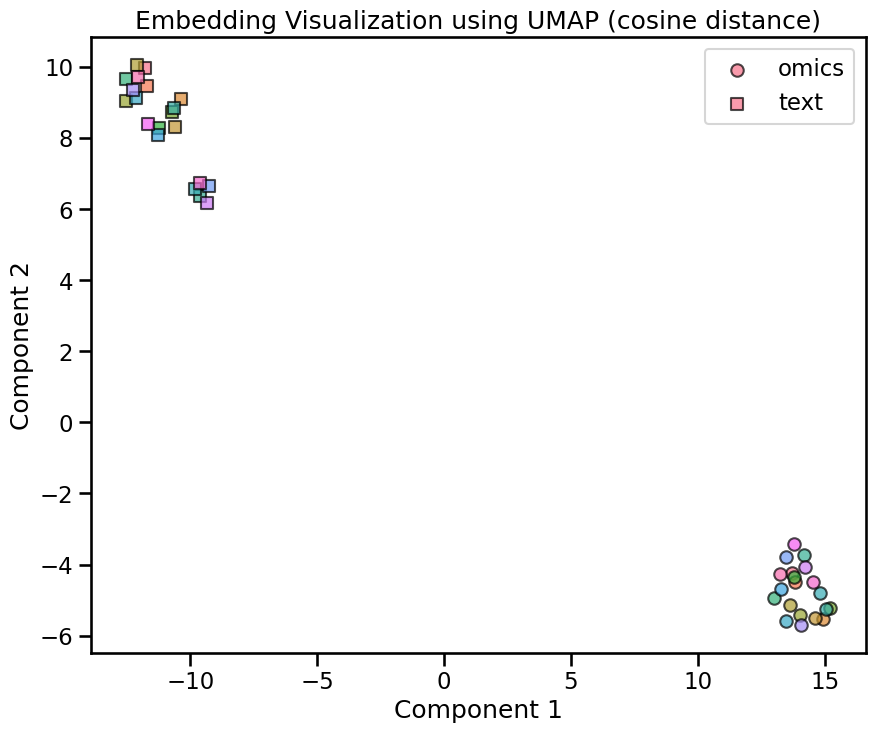

In [38]:
from mmcontext.pl import visualize_embedding_clusters

visualize_embedding_clusters(emb_pair_df, method="umap", metric="cosine", n_neighbors=15, min_dist=0.1, random_state=42)

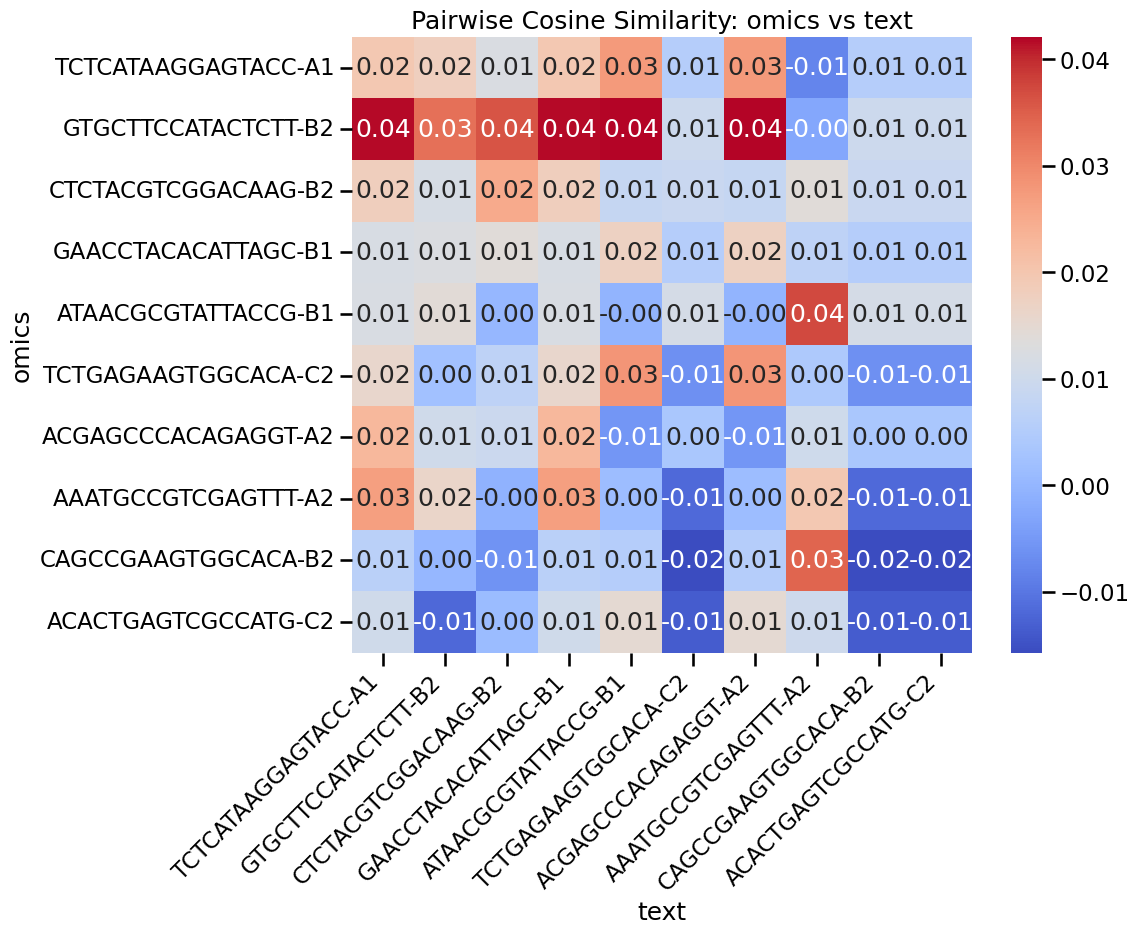

In [39]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", subset=10)

In [46]:
adata

AnnData object with n_obs × n_vars = 11175 × 28003
    obs: 'sample_id', 'replicate', 'condition', 'leiden', 'cluster_label', 'batch', '_scvi_batch', '_scvi_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'sample_index'
    var: 'gene_name', 'log1p_normalizer', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset_name', 'hvg', 'log1p', 'model_name', 'terms'
    obsm: 'X_cellwhisperer_umap', 'X_geneformer', 'X_hvg', 'X_pca', 'X_scvi', 'top_genes', 'transcriptome_embeds', 'mmcontext_emb', 'mmcontext_text_emb'
    layers: 'counts'

In [49]:
from mmcontext.pp import remove_zero_variance_cells, remove_zero_variance_genes

adata = remove_zero_variance_cells(adata)
adata = remove_zero_variance_genes(adata)

ImportError: cannot import name 'remove_zero_variance_cells' from 'mmcontext.pp' (/Users/mengerj/repos/mmcontext/src/mmcontext/pp/__init__.py)

In [42]:
from mmcontext.eval import scibEvaluator

evalutator = scibEvaluator(
    adata=adata,
    batch_key="batch",
    label_key="cluster_lavel",
    embedding_key=["mmcontext_emb", "mmcontext_text_emb", "X_geneformer", "X_hvg", "X_pca", "X_scvi"],
    n_top_genes=5000,
    max_cells=5000,
)
res = evalutator.evaluate()

HVG


Error in data reduction: Bin edges must be unique: Index([               -inf,  -2.892823703725029, -0.6085385346302277,
       0.09924078048896734, 0.09924078048896734, 0.09924079373444396,
       0.14027225325936107, 0.18885910880786402, 0.23705809401106778,
          0.30732003013017,  0.4241397468442167,   0.611900446591554,
        0.9100024470921467,  1.3157359159517066,  1.9957290970961805,
         2.822801220996513,   3.787105232711744,    5.15218205363662,
         7.423641985710012,  100.20904103227615,                 inf],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg
Using full data for metrics computation.


HVG
Cluster for cluster_0.2 with leiden


KeyError: 'No "neighbors" in .uns'